In [1]:
import pandas as pd 
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [32]:
byd=pd.read_excel(r"./BYD.xlsx") 
byd["log_return"]=np.log(byd["return"]+1)
byd["percentage_log_return"]=100*byd["log_return"]
mean=byd["BYD"].mean()
std=byd["BYD"].std()
byd["normalized_price"]=(byd["BYD"]-mean)/std

## Processing Data

In [3]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]
def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [38]:
def return_set(set1,set2,window_size):
    train_x,train_x_unseen=prepare_data_x(np.array(train_set["normalized_price"]),window_size)
    train_y=prepare_data_y(np.array(train_set["normalized_price"]), window_size)
    set2_x,set2_x_unseen=prepare_data_x(np.array(set2["normalized_price"]),window_size)
    set2_y=prepare_data_y(np.array(set2["normalized_price"]), window_size)
    dataset_train = TimeSeriesDataset(train_x, train_y)
    dataset2 = TimeSeriesDataset(set2_x, set2_y)
    return dataset_train,dataset2

## LSTM Network

In [39]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):#input_size is future num
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)
    def forward(self, x):
        batchsize = x.shape[0]
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

def model_training(dataloader):
    loss_list=[]
    validation_loss=[]
    model = LSTMModel(input_size=input_size, hidden_layer_size=hidden_layer_size, num_layers=num_layers, output_size=1, dropout=dropout)
    # 定义损失函数和优化器
    #criterion = nn.MSELoss()#收益率做标签使用这个函数
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
    for epoch in range(num_epoch):
        epoch_loss=0
        for idx, (x, y) in enumerate(dataloader):

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += (loss.detach().item() / batch_size)
           
        val_out = model(torch.tensor(dataset_val.x))
        val_loss = criterion(val_out.contiguous(), torch.tensor(dataset_val.y).contiguous()).detach().numpy()
        print('Epoch [{}/{}],  Loss: {:.4f},  Validation_Loss:{:.4f}'
            .format(epoch+1, num_epoch, epoch_loss,val_loss))

        loss_list.append(loss.item())
        validation_loss.append(val_loss)
    return model,loss_list,validation_loss  

def new_model_training(dataloader):
    loss_list=[]
    model = LSTMModel(input_size=input_size, hidden_layer_size=hidden_layer_size, num_layers=num_layers, output_size=1, dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
    for epoch in range(num_epoch):
        epoch_loss=0
        for idx, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += (loss.detach().item() / batch_size)
           
        print('Epoch [{}/{}],  Loss: {:.4f}, '
            .format(epoch+1, num_epoch, epoch_loss))

        loss_list.append(loss.item())
    return model,loss_list

## Pre Train

Epoch [1/200],  Loss: 0.1919,  Validation_Loss:0.2884
Epoch [2/200],  Loss: 0.0475,  Validation_Loss:0.1869
Epoch [3/200],  Loss: 0.0259,  Validation_Loss:0.0792
Epoch [4/200],  Loss: 0.0147,  Validation_Loss:0.0333
Epoch [5/200],  Loss: 0.0112,  Validation_Loss:0.0251
Epoch [6/200],  Loss: 0.0092,  Validation_Loss:0.0240
Epoch [7/200],  Loss: 0.0091,  Validation_Loss:0.0180
Epoch [8/200],  Loss: 0.0082,  Validation_Loss:0.0159
Epoch [9/200],  Loss: 0.0080,  Validation_Loss:0.0198
Epoch [10/200],  Loss: 0.0080,  Validation_Loss:0.0189
Epoch [11/200],  Loss: 0.0073,  Validation_Loss:0.0179
Epoch [12/200],  Loss: 0.0071,  Validation_Loss:0.0159
Epoch [13/200],  Loss: 0.0069,  Validation_Loss:0.0166
Epoch [14/200],  Loss: 0.0064,  Validation_Loss:0.0182
Epoch [15/200],  Loss: 0.0065,  Validation_Loss:0.0159
Epoch [16/200],  Loss: 0.0062,  Validation_Loss:0.0172
Epoch [17/200],  Loss: 0.0067,  Validation_Loss:0.0179
Epoch [18/200],  Loss: 0.0066,  Validation_Loss:0.0117
Epoch [19/200],  Lo

Epoch [150/200],  Loss: 0.0044,  Validation_Loss:0.0104
Epoch [151/200],  Loss: 0.0042,  Validation_Loss:0.0110
Epoch [152/200],  Loss: 0.0042,  Validation_Loss:0.0116
Epoch [153/200],  Loss: 0.0043,  Validation_Loss:0.0118
Epoch [154/200],  Loss: 0.0044,  Validation_Loss:0.0126
Epoch [155/200],  Loss: 0.0042,  Validation_Loss:0.0115
Epoch [156/200],  Loss: 0.0044,  Validation_Loss:0.0108
Epoch [157/200],  Loss: 0.0044,  Validation_Loss:0.0115
Epoch [158/200],  Loss: 0.0043,  Validation_Loss:0.0097
Epoch [159/200],  Loss: 0.0040,  Validation_Loss:0.0126
Epoch [160/200],  Loss: 0.0044,  Validation_Loss:0.0094
Epoch [161/200],  Loss: 0.0044,  Validation_Loss:0.0103
Epoch [162/200],  Loss: 0.0046,  Validation_Loss:0.0114
Epoch [163/200],  Loss: 0.0041,  Validation_Loss:0.0099
Epoch [164/200],  Loss: 0.0040,  Validation_Loss:0.0111
Epoch [165/200],  Loss: 0.0043,  Validation_Loss:0.0113
Epoch [166/200],  Loss: 0.0042,  Validation_Loss:0.0109
Epoch [167/200],  Loss: 0.0042,  Validation_Loss

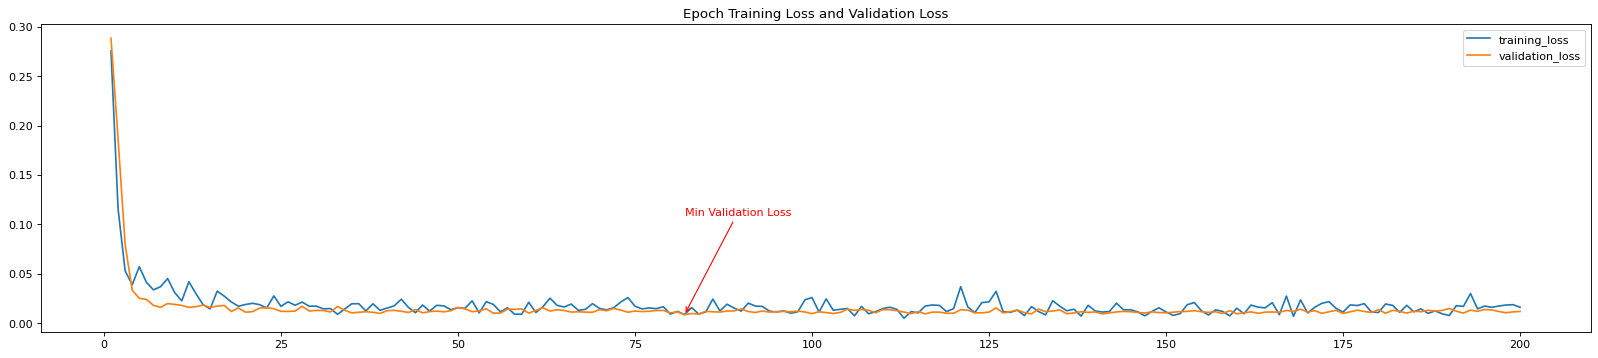

In [44]:
#config
#predict using price
window_size=5
batch_size=64
input_size=1
hidden_layer_size=32
num_layers=2
dropout=0.2
learning_rate=0.001
num_epoch=200


#pre_train train and validation
train_set=byd[byd["date"]<'2017-01-01']
validation_set=byd[(byd["date"]>='2017-01-01') & (byd["date"]<'2018-01-01')]
dataset_train,dataset_val=return_set(train_set,validation_set,window_size)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

#train train set and test set
byd2=byd[(byd["date"]>='2013-01-01')]
split=len(byd2[byd2["date"]<'2018-01-01'])
new_train_set=byd2.iloc[:split,:]
test_set=byd2.iloc[split-window_size:,:]
dataset_new_train,dataset_test=return_set(new_train_set,test_set,window_size)
new_train_dataloader = DataLoader(dataset_new_train, batch_size=batch_size, shuffle=True)

#train
pre_train_model,loss_list,validation_loss = model_training(train_dataloader)


fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(range(1,len(loss_list)+1), loss_list,label="training_loss")
plt.plot(range(1,len(loss_list)+1), validation_loss,label="validation_loss")
# validation_loss min annotate
min_val_loss_index = np.argmin(validation_loss)
#color
arrowprops = dict(color='red', arrowstyle='->')
# add annotate
plt.annotate('Min Validation Loss', xy=(min_val_loss_index+1, validation_loss[min_val_loss_index]),
             xytext=(min_val_loss_index+1, validation_loss[min_val_loss_index]+0.1),
             arrowprops=arrowprops, color='red')
plt.title("Epoch Training Loss and Validation Loss")
plt.legend()
plt.show()    

## Train

Epoch [1/113],  Loss: 0.2835, 
Epoch [2/113],  Loss: 0.0886, 
Epoch [3/113],  Loss: 0.0199, 
Epoch [4/113],  Loss: 0.0129, 
Epoch [5/113],  Loss: 0.0114, 
Epoch [6/113],  Loss: 0.0099, 
Epoch [7/113],  Loss: 0.0093, 
Epoch [8/113],  Loss: 0.0089, 
Epoch [9/113],  Loss: 0.0084, 
Epoch [10/113],  Loss: 0.0086, 
Epoch [11/113],  Loss: 0.0077, 
Epoch [12/113],  Loss: 0.0072, 
Epoch [13/113],  Loss: 0.0072, 
Epoch [14/113],  Loss: 0.0074, 
Epoch [15/113],  Loss: 0.0067, 
Epoch [16/113],  Loss: 0.0069, 
Epoch [17/113],  Loss: 0.0067, 
Epoch [18/113],  Loss: 0.0064, 
Epoch [19/113],  Loss: 0.0060, 
Epoch [20/113],  Loss: 0.0061, 
Epoch [21/113],  Loss: 0.0062, 
Epoch [22/113],  Loss: 0.0066, 
Epoch [23/113],  Loss: 0.0059, 
Epoch [24/113],  Loss: 0.0060, 
Epoch [25/113],  Loss: 0.0056, 
Epoch [26/113],  Loss: 0.0052, 
Epoch [27/113],  Loss: 0.0056, 
Epoch [28/113],  Loss: 0.0054, 
Epoch [29/113],  Loss: 0.0051, 
Epoch [30/113],  Loss: 0.0053, 
Epoch [31/113],  Loss: 0.0047, 
Epoch [32/113],  

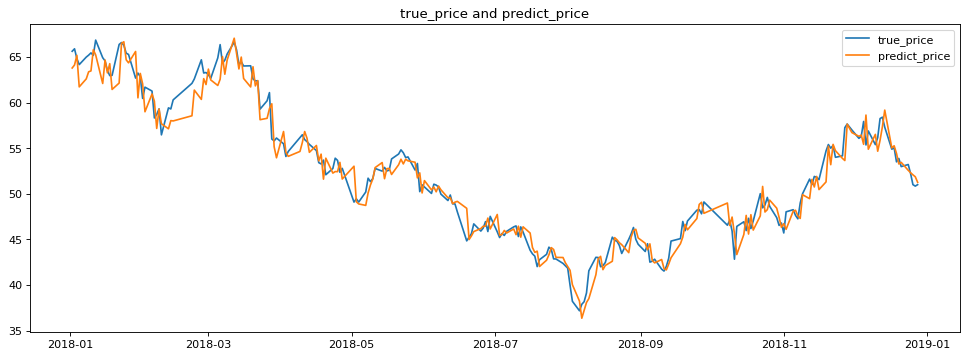

In [18]:
num_epoch=min_val_loss_index
model,loss_list= new_model_training(new_train_dataloader)

true_frame=byd2[byd2["date"]>='2018-01-01']
x_ticks=true_frame["date"].tolist()
true_price=(true_frame["BYD"]).tolist()
predict_price=model(torch.tensor(dataset_test.x)).detach().numpy()*std+mean
fig = figure(figsize=(15, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(x_ticks, true_price,label="true_price")
plt.plot(x_ticks, predict_price,label="predict_price")
plt.title("true_price and predict_price")
plt.legend()
plt.show()

## Different Values of Sequence

Epoch [1/200],  Loss: 0.5942,  Validation_Loss:0.0988
Epoch [2/200],  Loss: 0.0857,  Validation_Loss:0.0407
Epoch [3/200],  Loss: 0.0451,  Validation_Loss:0.0231
Epoch [4/200],  Loss: 0.0392,  Validation_Loss:0.0191
Epoch [5/200],  Loss: 0.0335,  Validation_Loss:0.0176
Epoch [6/200],  Loss: 0.0325,  Validation_Loss:0.0166
Epoch [7/200],  Loss: 0.0282,  Validation_Loss:0.0131
Epoch [8/200],  Loss: 0.0276,  Validation_Loss:0.0142
Epoch [9/200],  Loss: 0.0248,  Validation_Loss:0.0146
Epoch [10/200],  Loss: 0.0231,  Validation_Loss:0.0179
Epoch [11/200],  Loss: 0.0240,  Validation_Loss:0.0137
Epoch [12/200],  Loss: 0.0227,  Validation_Loss:0.0133
Epoch [13/200],  Loss: 0.0234,  Validation_Loss:0.0136
Epoch [14/200],  Loss: 0.0243,  Validation_Loss:0.0110
Epoch [15/200],  Loss: 0.0206,  Validation_Loss:0.0122
Epoch [16/200],  Loss: 0.0206,  Validation_Loss:0.0120
Epoch [17/200],  Loss: 0.0208,  Validation_Loss:0.0116
Epoch [18/200],  Loss: 0.0202,  Validation_Loss:0.0175
Epoch [19/200],  Lo

Epoch [151/200],  Loss: 0.0181,  Validation_Loss:0.0127
Epoch [152/200],  Loss: 0.0174,  Validation_Loss:0.0100
Epoch [153/200],  Loss: 0.0185,  Validation_Loss:0.0098
Epoch [154/200],  Loss: 0.0168,  Validation_Loss:0.0109
Epoch [155/200],  Loss: 0.0171,  Validation_Loss:0.0124
Epoch [156/200],  Loss: 0.0169,  Validation_Loss:0.0109
Epoch [157/200],  Loss: 0.0165,  Validation_Loss:0.0132
Epoch [158/200],  Loss: 0.0162,  Validation_Loss:0.0119
Epoch [159/200],  Loss: 0.0173,  Validation_Loss:0.0144
Epoch [160/200],  Loss: 0.0184,  Validation_Loss:0.0099
Epoch [161/200],  Loss: 0.0163,  Validation_Loss:0.0133
Epoch [162/200],  Loss: 0.0176,  Validation_Loss:0.0098
Epoch [163/200],  Loss: 0.0173,  Validation_Loss:0.0095
Epoch [164/200],  Loss: 0.0175,  Validation_Loss:0.0096
Epoch [165/200],  Loss: 0.0168,  Validation_Loss:0.0113
Epoch [166/200],  Loss: 0.0173,  Validation_Loss:0.0105
Epoch [167/200],  Loss: 0.0194,  Validation_Loss:0.0137
Epoch [168/200],  Loss: 0.0164,  Validation_Loss

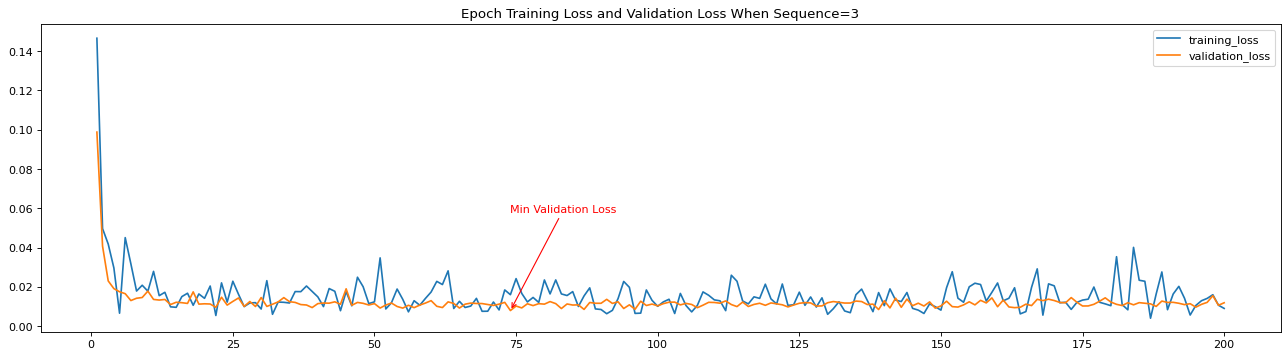

Epoch [1/73],  Loss: 0.5509, 
Epoch [2/73],  Loss: 0.0775, 
Epoch [3/73],  Loss: 0.0442, 
Epoch [4/73],  Loss: 0.0339, 
Epoch [5/73],  Loss: 0.0321, 
Epoch [6/73],  Loss: 0.0294, 
Epoch [7/73],  Loss: 0.0287, 
Epoch [8/73],  Loss: 0.0291, 
Epoch [9/73],  Loss: 0.0275, 
Epoch [10/73],  Loss: 0.0255, 
Epoch [11/73],  Loss: 0.0241, 
Epoch [12/73],  Loss: 0.0240, 
Epoch [13/73],  Loss: 0.0226, 
Epoch [14/73],  Loss: 0.0221, 
Epoch [15/73],  Loss: 0.0220, 
Epoch [16/73],  Loss: 0.0223, 
Epoch [17/73],  Loss: 0.0213, 
Epoch [18/73],  Loss: 0.0199, 
Epoch [19/73],  Loss: 0.0209, 
Epoch [20/73],  Loss: 0.0211, 
Epoch [21/73],  Loss: 0.0198, 
Epoch [22/73],  Loss: 0.0210, 
Epoch [23/73],  Loss: 0.0200, 
Epoch [24/73],  Loss: 0.0204, 
Epoch [25/73],  Loss: 0.0203, 
Epoch [26/73],  Loss: 0.0187, 
Epoch [27/73],  Loss: 0.0195, 
Epoch [28/73],  Loss: 0.0192, 
Epoch [29/73],  Loss: 0.0188, 
Epoch [30/73],  Loss: 0.0193, 
Epoch [31/73],  Loss: 0.0182, 
Epoch [32/73],  Loss: 0.0178, 
Epoch [33/73],  L

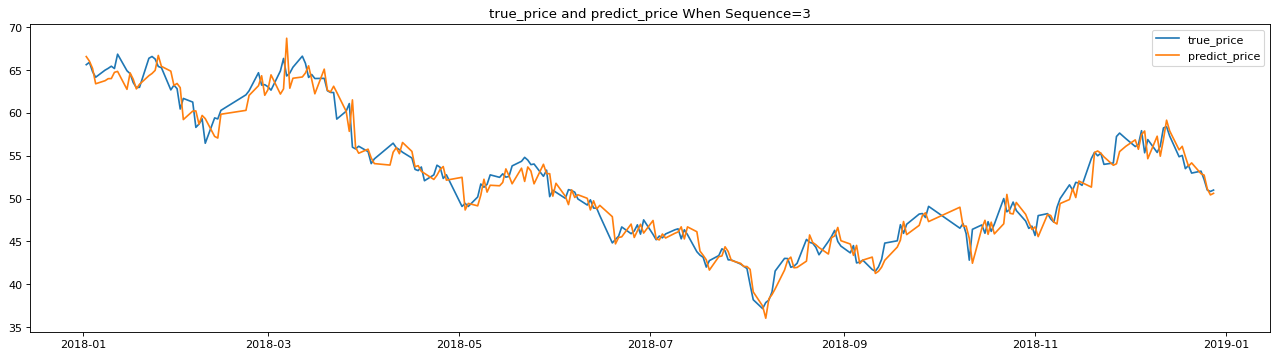

Mean Squared Error (MSE): 1.9831675573117242
Root Mean Squared Error (RMSE): 1.4082498206325909
Mean Absolute Error (MAE): 1.0818547246865962
R-squared (R^2): 0.9652367463050286
Epoch [1/200],  Loss: 0.4648,  Validation_Loss:0.2032
Epoch [2/200],  Loss: 0.0842,  Validation_Loss:0.0465
Epoch [3/200],  Loss: 0.0465,  Validation_Loss:0.0278
Epoch [4/200],  Loss: 0.0380,  Validation_Loss:0.0260
Epoch [5/200],  Loss: 0.0348,  Validation_Loss:0.0247
Epoch [6/200],  Loss: 0.0302,  Validation_Loss:0.0172
Epoch [7/200],  Loss: 0.0295,  Validation_Loss:0.0189
Epoch [8/200],  Loss: 0.0273,  Validation_Loss:0.0207
Epoch [9/200],  Loss: 0.0250,  Validation_Loss:0.0139
Epoch [10/200],  Loss: 0.0258,  Validation_Loss:0.0152
Epoch [11/200],  Loss: 0.0243,  Validation_Loss:0.0120
Epoch [12/200],  Loss: 0.0234,  Validation_Loss:0.0144
Epoch [13/200],  Loss: 0.0227,  Validation_Loss:0.0170
Epoch [14/200],  Loss: 0.0216,  Validation_Loss:0.0158
Epoch [15/200],  Loss: 0.0206,  Validation_Loss:0.0151
Epoch 

Epoch [147/200],  Loss: 0.0177,  Validation_Loss:0.0115
Epoch [148/200],  Loss: 0.0161,  Validation_Loss:0.0123
Epoch [149/200],  Loss: 0.0183,  Validation_Loss:0.0111
Epoch [150/200],  Loss: 0.0163,  Validation_Loss:0.0095
Epoch [151/200],  Loss: 0.0167,  Validation_Loss:0.0125
Epoch [152/200],  Loss: 0.0171,  Validation_Loss:0.0143
Epoch [153/200],  Loss: 0.0188,  Validation_Loss:0.0114
Epoch [154/200],  Loss: 0.0178,  Validation_Loss:0.0107
Epoch [155/200],  Loss: 0.0170,  Validation_Loss:0.0119
Epoch [156/200],  Loss: 0.0179,  Validation_Loss:0.0117
Epoch [157/200],  Loss: 0.0185,  Validation_Loss:0.0139
Epoch [158/200],  Loss: 0.0180,  Validation_Loss:0.0128
Epoch [159/200],  Loss: 0.0170,  Validation_Loss:0.0156
Epoch [160/200],  Loss: 0.0191,  Validation_Loss:0.0119
Epoch [161/200],  Loss: 0.0166,  Validation_Loss:0.0117
Epoch [162/200],  Loss: 0.0156,  Validation_Loss:0.0115
Epoch [163/200],  Loss: 0.0163,  Validation_Loss:0.0124
Epoch [164/200],  Loss: 0.0175,  Validation_Loss

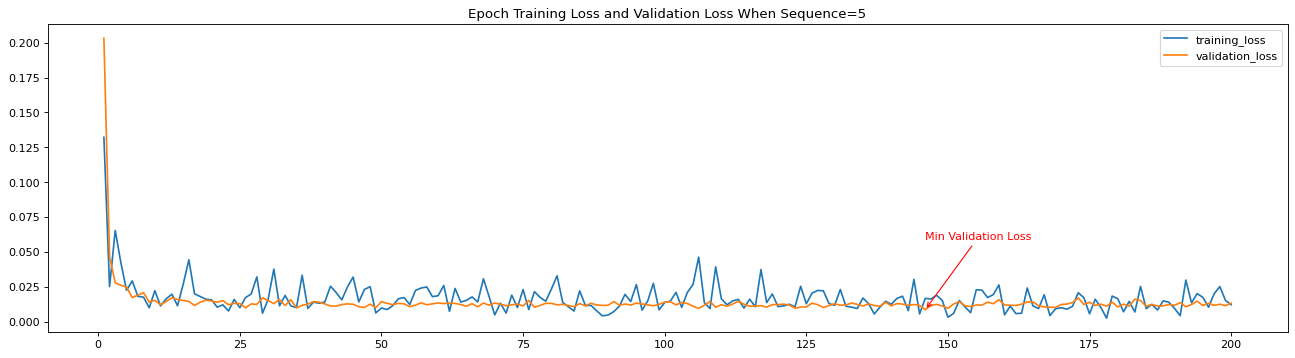

Epoch [1/145],  Loss: 0.6002, 
Epoch [2/145],  Loss: 0.0771, 
Epoch [3/145],  Loss: 0.0464, 
Epoch [4/145],  Loss: 0.0423, 
Epoch [5/145],  Loss: 0.0379, 
Epoch [6/145],  Loss: 0.0348, 
Epoch [7/145],  Loss: 0.0316, 
Epoch [8/145],  Loss: 0.0259, 
Epoch [9/145],  Loss: 0.0278, 
Epoch [10/145],  Loss: 0.0272, 
Epoch [11/145],  Loss: 0.0271, 
Epoch [12/145],  Loss: 0.0229, 
Epoch [13/145],  Loss: 0.0238, 
Epoch [14/145],  Loss: 0.0228, 
Epoch [15/145],  Loss: 0.0238, 
Epoch [16/145],  Loss: 0.0222, 
Epoch [17/145],  Loss: 0.0227, 
Epoch [18/145],  Loss: 0.0215, 
Epoch [19/145],  Loss: 0.0231, 
Epoch [20/145],  Loss: 0.0210, 
Epoch [21/145],  Loss: 0.0192, 
Epoch [22/145],  Loss: 0.0209, 
Epoch [23/145],  Loss: 0.0214, 
Epoch [24/145],  Loss: 0.0205, 
Epoch [25/145],  Loss: 0.0215, 
Epoch [26/145],  Loss: 0.0206, 
Epoch [27/145],  Loss: 0.0207, 
Epoch [28/145],  Loss: 0.0194, 
Epoch [29/145],  Loss: 0.0189, 
Epoch [30/145],  Loss: 0.0195, 
Epoch [31/145],  Loss: 0.0194, 
Epoch [32/145],  

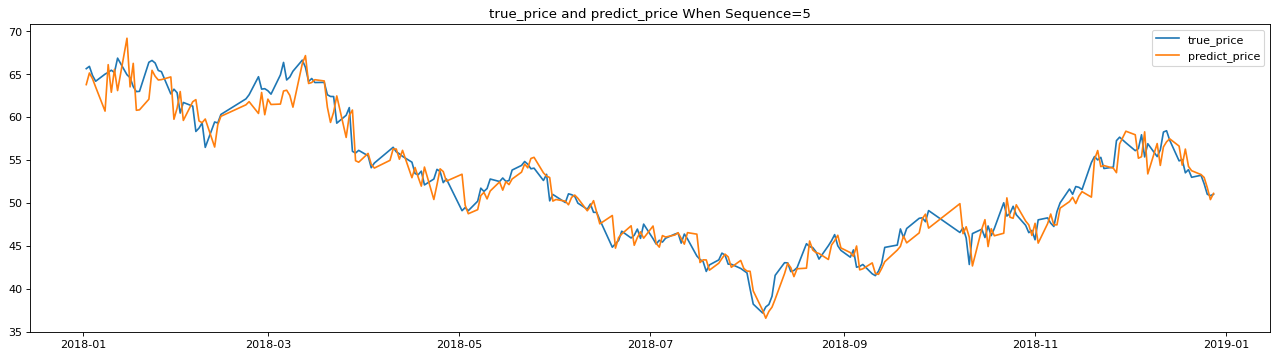

Mean Squared Error (MSE): 2.745363507868874
Root Mean Squared Error (RMSE): 1.6569138504668472
Mean Absolute Error (MAE): 1.2452129802829446
R-squared (R^2): 0.9518760945049279
Epoch [1/200],  Loss: 0.3350,  Validation_Loss:0.0842
Epoch [2/200],  Loss: 0.0557,  Validation_Loss:0.0259
Epoch [3/200],  Loss: 0.0406,  Validation_Loss:0.0201
Epoch [4/200],  Loss: 0.0340,  Validation_Loss:0.0193
Epoch [5/200],  Loss: 0.0308,  Validation_Loss:0.0170
Epoch [6/200],  Loss: 0.0269,  Validation_Loss:0.0186
Epoch [7/200],  Loss: 0.0274,  Validation_Loss:0.0185
Epoch [8/200],  Loss: 0.0251,  Validation_Loss:0.0116
Epoch [9/200],  Loss: 0.0255,  Validation_Loss:0.0136
Epoch [10/200],  Loss: 0.0226,  Validation_Loss:0.0136
Epoch [11/200],  Loss: 0.0209,  Validation_Loss:0.0167
Epoch [12/200],  Loss: 0.0231,  Validation_Loss:0.0133
Epoch [13/200],  Loss: 0.0218,  Validation_Loss:0.0118
Epoch [14/200],  Loss: 0.0208,  Validation_Loss:0.0156
Epoch [15/200],  Loss: 0.0199,  Validation_Loss:0.0117
Epoch [

Epoch [147/200],  Loss: 0.0175,  Validation_Loss:0.0112
Epoch [148/200],  Loss: 0.0175,  Validation_Loss:0.0143
Epoch [149/200],  Loss: 0.0161,  Validation_Loss:0.0103
Epoch [150/200],  Loss: 0.0161,  Validation_Loss:0.0114
Epoch [151/200],  Loss: 0.0170,  Validation_Loss:0.0129
Epoch [152/200],  Loss: 0.0169,  Validation_Loss:0.0122
Epoch [153/200],  Loss: 0.0168,  Validation_Loss:0.0133
Epoch [154/200],  Loss: 0.0161,  Validation_Loss:0.0125
Epoch [155/200],  Loss: 0.0167,  Validation_Loss:0.0108
Epoch [156/200],  Loss: 0.0170,  Validation_Loss:0.0119
Epoch [157/200],  Loss: 0.0181,  Validation_Loss:0.0116
Epoch [158/200],  Loss: 0.0158,  Validation_Loss:0.0141
Epoch [159/200],  Loss: 0.0172,  Validation_Loss:0.0172
Epoch [160/200],  Loss: 0.0164,  Validation_Loss:0.0120
Epoch [161/200],  Loss: 0.0181,  Validation_Loss:0.0110
Epoch [162/200],  Loss: 0.0175,  Validation_Loss:0.0129
Epoch [163/200],  Loss: 0.0176,  Validation_Loss:0.0125
Epoch [164/200],  Loss: 0.0163,  Validation_Loss

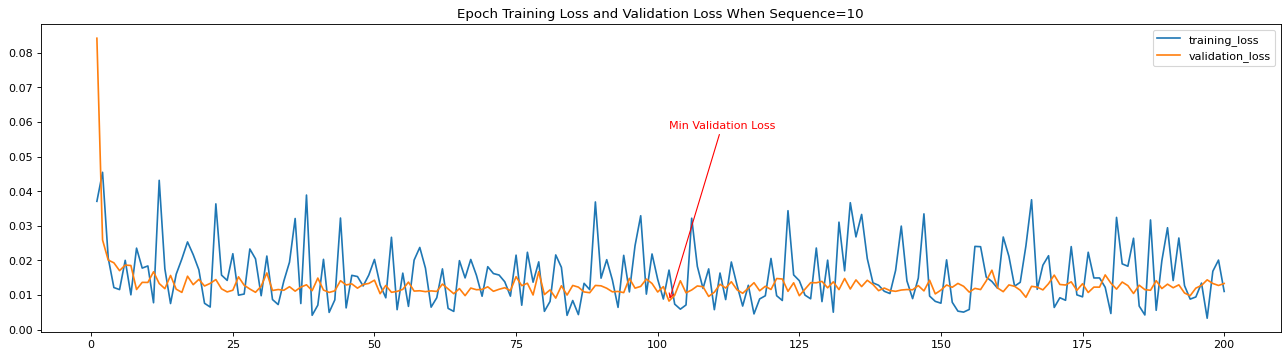

Epoch [1/101],  Loss: 0.6404, 
Epoch [2/101],  Loss: 0.0650, 
Epoch [3/101],  Loss: 0.0390, 
Epoch [4/101],  Loss: 0.0322, 
Epoch [5/101],  Loss: 0.0335, 
Epoch [6/101],  Loss: 0.0300, 
Epoch [7/101],  Loss: 0.0260, 
Epoch [8/101],  Loss: 0.0258, 
Epoch [9/101],  Loss: 0.0250, 
Epoch [10/101],  Loss: 0.0256, 
Epoch [11/101],  Loss: 0.0241, 
Epoch [12/101],  Loss: 0.0238, 
Epoch [13/101],  Loss: 0.0225, 
Epoch [14/101],  Loss: 0.0210, 
Epoch [15/101],  Loss: 0.0209, 
Epoch [16/101],  Loss: 0.0214, 
Epoch [17/101],  Loss: 0.0201, 
Epoch [18/101],  Loss: 0.0203, 
Epoch [19/101],  Loss: 0.0203, 
Epoch [20/101],  Loss: 0.0211, 
Epoch [21/101],  Loss: 0.0198, 
Epoch [22/101],  Loss: 0.0191, 
Epoch [23/101],  Loss: 0.0198, 
Epoch [24/101],  Loss: 0.0183, 
Epoch [25/101],  Loss: 0.0184, 
Epoch [26/101],  Loss: 0.0186, 
Epoch [27/101],  Loss: 0.0202, 
Epoch [28/101],  Loss: 0.0199, 
Epoch [29/101],  Loss: 0.0191, 
Epoch [30/101],  Loss: 0.0185, 
Epoch [31/101],  Loss: 0.0176, 
Epoch [32/101],  

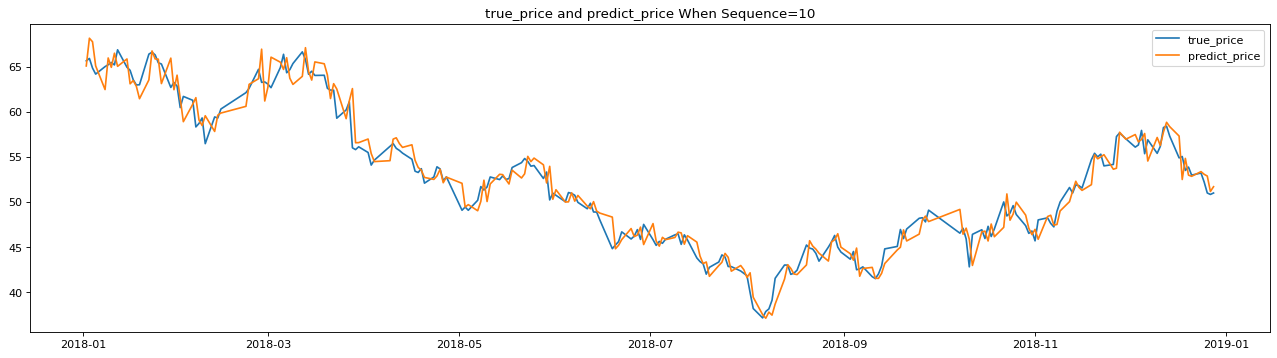

Mean Squared Error (MSE): 2.057193734963541
Root Mean Squared Error (RMSE): 1.4342920675244428
Mean Absolute Error (MAE): 1.0865464514923604
R-squared (R^2): 0.9639391298810954
Epoch [1/200],  Loss: 0.4347,  Validation_Loss:0.0496
Epoch [2/200],  Loss: 0.0585,  Validation_Loss:0.0263
Epoch [3/200],  Loss: 0.0428,  Validation_Loss:0.0193
Epoch [4/200],  Loss: 0.0378,  Validation_Loss:0.0203
Epoch [5/200],  Loss: 0.0346,  Validation_Loss:0.0187
Epoch [6/200],  Loss: 0.0306,  Validation_Loss:0.0280
Epoch [7/200],  Loss: 0.0317,  Validation_Loss:0.0150
Epoch [8/200],  Loss: 0.0271,  Validation_Loss:0.0153
Epoch [9/200],  Loss: 0.0257,  Validation_Loss:0.0148
Epoch [10/200],  Loss: 0.0255,  Validation_Loss:0.0155
Epoch [11/200],  Loss: 0.0249,  Validation_Loss:0.0130
Epoch [12/200],  Loss: 0.0233,  Validation_Loss:0.0153
Epoch [13/200],  Loss: 0.0234,  Validation_Loss:0.0120
Epoch [14/200],  Loss: 0.0220,  Validation_Loss:0.0148
Epoch [15/200],  Loss: 0.0231,  Validation_Loss:0.0113
Epoch [

Epoch [147/200],  Loss: 0.0176,  Validation_Loss:0.0120
Epoch [148/200],  Loss: 0.0171,  Validation_Loss:0.0105
Epoch [149/200],  Loss: 0.0171,  Validation_Loss:0.0134
Epoch [150/200],  Loss: 0.0175,  Validation_Loss:0.0113
Epoch [151/200],  Loss: 0.0181,  Validation_Loss:0.0106
Epoch [152/200],  Loss: 0.0176,  Validation_Loss:0.0161
Epoch [153/200],  Loss: 0.0166,  Validation_Loss:0.0141
Epoch [154/200],  Loss: 0.0174,  Validation_Loss:0.0126
Epoch [155/200],  Loss: 0.0173,  Validation_Loss:0.0116
Epoch [156/200],  Loss: 0.0181,  Validation_Loss:0.0111
Epoch [157/200],  Loss: 0.0168,  Validation_Loss:0.0123
Epoch [158/200],  Loss: 0.0171,  Validation_Loss:0.0125
Epoch [159/200],  Loss: 0.0170,  Validation_Loss:0.0121
Epoch [160/200],  Loss: 0.0171,  Validation_Loss:0.0132
Epoch [161/200],  Loss: 0.0166,  Validation_Loss:0.0108
Epoch [162/200],  Loss: 0.0166,  Validation_Loss:0.0113
Epoch [163/200],  Loss: 0.0173,  Validation_Loss:0.0116
Epoch [164/200],  Loss: 0.0172,  Validation_Loss

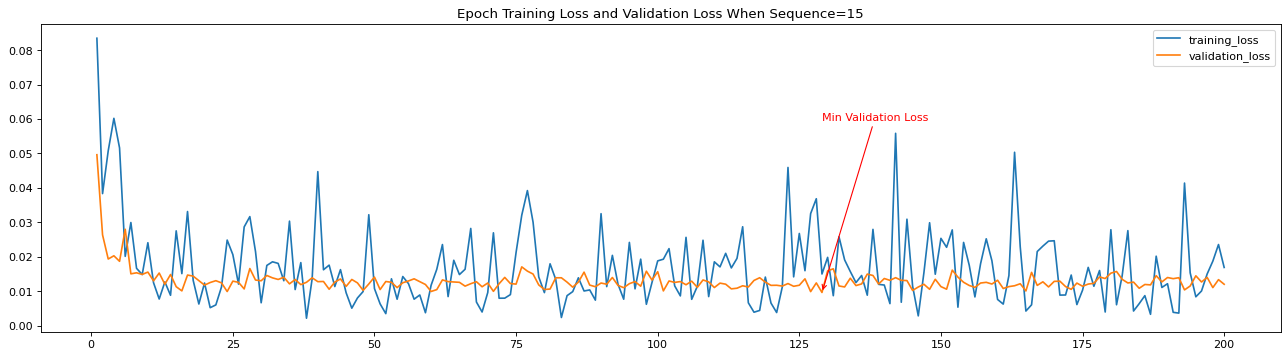

Epoch [1/128],  Loss: 0.4846, 
Epoch [2/128],  Loss: 0.0657, 
Epoch [3/128],  Loss: 0.0379, 
Epoch [4/128],  Loss: 0.0331, 
Epoch [5/128],  Loss: 0.0314, 
Epoch [6/128],  Loss: 0.0299, 
Epoch [7/128],  Loss: 0.0289, 
Epoch [8/128],  Loss: 0.0276, 
Epoch [9/128],  Loss: 0.0260, 
Epoch [10/128],  Loss: 0.0254, 
Epoch [11/128],  Loss: 0.0237, 
Epoch [12/128],  Loss: 0.0228, 
Epoch [13/128],  Loss: 0.0238, 
Epoch [14/128],  Loss: 0.0221, 
Epoch [15/128],  Loss: 0.0235, 
Epoch [16/128],  Loss: 0.0213, 
Epoch [17/128],  Loss: 0.0225, 
Epoch [18/128],  Loss: 0.0211, 
Epoch [19/128],  Loss: 0.0207, 
Epoch [20/128],  Loss: 0.0216, 
Epoch [21/128],  Loss: 0.0199, 
Epoch [22/128],  Loss: 0.0214, 
Epoch [23/128],  Loss: 0.0190, 
Epoch [24/128],  Loss: 0.0206, 
Epoch [25/128],  Loss: 0.0204, 
Epoch [26/128],  Loss: 0.0208, 
Epoch [27/128],  Loss: 0.0193, 
Epoch [28/128],  Loss: 0.0177, 
Epoch [29/128],  Loss: 0.0206, 
Epoch [30/128],  Loss: 0.0191, 
Epoch [31/128],  Loss: 0.0192, 
Epoch [32/128],  

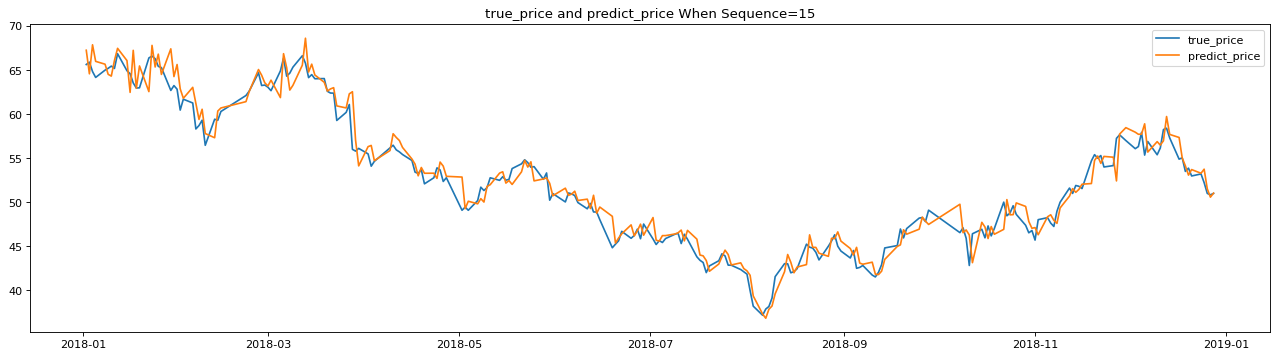

Mean Squared Error (MSE): 2.096471420379177
Root Mean Squared Error (RMSE): 1.4479196871301865
Mean Absolute Error (MAE): 1.0787007612286268
R-squared (R^2): 0.9632506252019921
Epoch [1/200],  Loss: 0.4973,  Validation_Loss:0.0486
Epoch [2/200],  Loss: 0.0562,  Validation_Loss:0.0237
Epoch [3/200],  Loss: 0.0427,  Validation_Loss:0.0206
Epoch [4/200],  Loss: 0.0372,  Validation_Loss:0.0173
Epoch [5/200],  Loss: 0.0345,  Validation_Loss:0.0187
Epoch [6/200],  Loss: 0.0320,  Validation_Loss:0.0177
Epoch [7/200],  Loss: 0.0304,  Validation_Loss:0.0148
Epoch [8/200],  Loss: 0.0280,  Validation_Loss:0.0155
Epoch [9/200],  Loss: 0.0270,  Validation_Loss:0.0188
Epoch [10/200],  Loss: 0.0242,  Validation_Loss:0.0159
Epoch [11/200],  Loss: 0.0247,  Validation_Loss:0.0125
Epoch [12/200],  Loss: 0.0247,  Validation_Loss:0.0137
Epoch [13/200],  Loss: 0.0243,  Validation_Loss:0.0151
Epoch [14/200],  Loss: 0.0224,  Validation_Loss:0.0107
Epoch [15/200],  Loss: 0.0240,  Validation_Loss:0.0126
Epoch [

Epoch [147/200],  Loss: 0.0180,  Validation_Loss:0.0121
Epoch [148/200],  Loss: 0.0162,  Validation_Loss:0.0151
Epoch [149/200],  Loss: 0.0167,  Validation_Loss:0.0126
Epoch [150/200],  Loss: 0.0172,  Validation_Loss:0.0121
Epoch [151/200],  Loss: 0.0177,  Validation_Loss:0.0116
Epoch [152/200],  Loss: 0.0175,  Validation_Loss:0.0128
Epoch [153/200],  Loss: 0.0163,  Validation_Loss:0.0137
Epoch [154/200],  Loss: 0.0164,  Validation_Loss:0.0128
Epoch [155/200],  Loss: 0.0166,  Validation_Loss:0.0140
Epoch [156/200],  Loss: 0.0155,  Validation_Loss:0.0122
Epoch [157/200],  Loss: 0.0161,  Validation_Loss:0.0155
Epoch [158/200],  Loss: 0.0164,  Validation_Loss:0.0141
Epoch [159/200],  Loss: 0.0164,  Validation_Loss:0.0119
Epoch [160/200],  Loss: 0.0169,  Validation_Loss:0.0140
Epoch [161/200],  Loss: 0.0164,  Validation_Loss:0.0140
Epoch [162/200],  Loss: 0.0159,  Validation_Loss:0.0132
Epoch [163/200],  Loss: 0.0160,  Validation_Loss:0.0159
Epoch [164/200],  Loss: 0.0167,  Validation_Loss

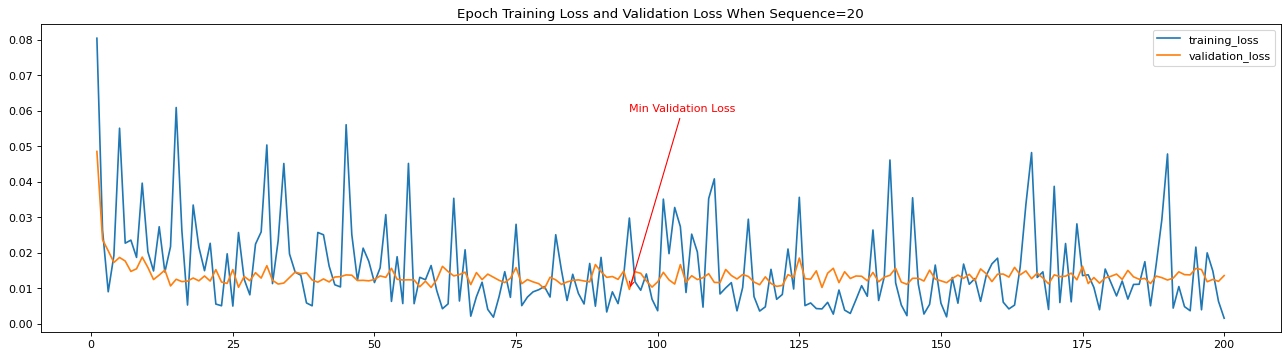

Epoch [1/94],  Loss: 0.4683, 
Epoch [2/94],  Loss: 0.0609, 
Epoch [3/94],  Loss: 0.0408, 
Epoch [4/94],  Loss: 0.0360, 
Epoch [5/94],  Loss: 0.0336, 
Epoch [6/94],  Loss: 0.0292, 
Epoch [7/94],  Loss: 0.0304, 
Epoch [8/94],  Loss: 0.0268, 
Epoch [9/94],  Loss: 0.0261, 
Epoch [10/94],  Loss: 0.0258, 
Epoch [11/94],  Loss: 0.0248, 
Epoch [12/94],  Loss: 0.0226, 
Epoch [13/94],  Loss: 0.0219, 
Epoch [14/94],  Loss: 0.0235, 
Epoch [15/94],  Loss: 0.0220, 
Epoch [16/94],  Loss: 0.0214, 
Epoch [17/94],  Loss: 0.0226, 
Epoch [18/94],  Loss: 0.0216, 
Epoch [19/94],  Loss: 0.0212, 
Epoch [20/94],  Loss: 0.0209, 
Epoch [21/94],  Loss: 0.0203, 
Epoch [22/94],  Loss: 0.0208, 
Epoch [23/94],  Loss: 0.0202, 
Epoch [24/94],  Loss: 0.0191, 
Epoch [25/94],  Loss: 0.0216, 
Epoch [26/94],  Loss: 0.0196, 
Epoch [27/94],  Loss: 0.0201, 
Epoch [28/94],  Loss: 0.0205, 
Epoch [29/94],  Loss: 0.0192, 
Epoch [30/94],  Loss: 0.0189, 
Epoch [31/94],  Loss: 0.0201, 
Epoch [32/94],  Loss: 0.0192, 
Epoch [33/94],  L

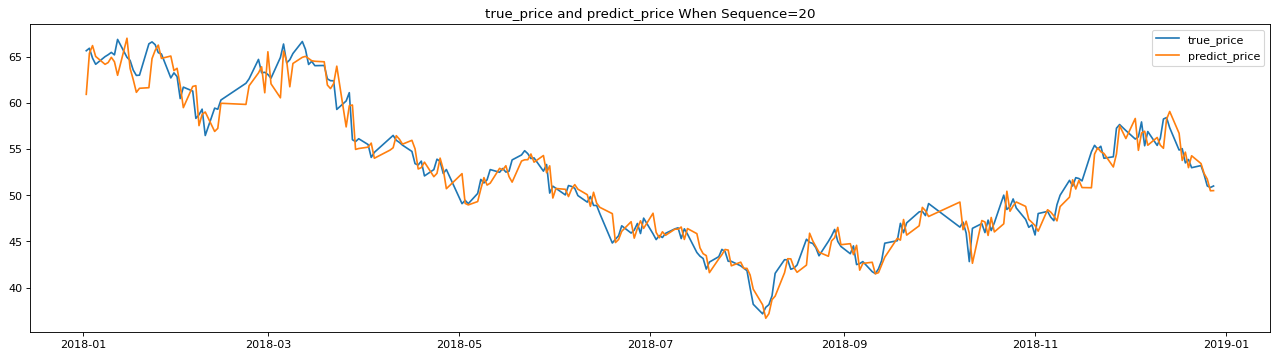

Mean Squared Error (MSE): 2.177213601417431
Root Mean Squared Error (RMSE): 1.4755384106885971
Mean Absolute Error (MAE): 1.1412935114941152
R-squared (R^2): 0.9618352829062947


In [48]:
window_sizes=[3,5,10,15,20]
batch_size=32
input_size=1
hidden_layer_size=32
num_layers=2
dropout=0.2
learning_rate=0.001
for window_size in window_sizes:
    num_epoch=200
    #pre train
    train_set=byd[byd["date"]<'2017-01-01']
    validation_set=byd[(byd["date"]>='2017-01-01') & (byd["date"]<'2018-01-01')]
    dataset_train,dataset_val=return_set(train_set,validation_set,window_size)
    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

    #train train set and test set
    byd2=byd[(byd["date"]>='2012-01-01')]
    split=len(byd2[byd2["date"]<'2018-01-01'])
    new_train_set=byd2.iloc[:split,:]
    test_set=byd2.iloc[split-window_size:,:]
    dataset_new_train,dataset_test=return_set(new_train_set,test_set,window_size)
    new_train_dataloader = DataLoader(dataset_new_train, batch_size=batch_size, shuffle=True)
    #train
    pre_train_model,loss_list,validation_loss = model_training(train_dataloader)


    fig = figure(figsize=(20, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(range(1,len(loss_list)+1), loss_list,label="training_loss")
    plt.plot(range(1,len(loss_list)+1), validation_loss,label="validation_loss")
    # validation_loss min annotate
    min_val_loss_index = np.argmin(validation_loss)
    print("min validation loss:", validation_loss[min_val_loss_index])
    #color
    arrowprops = dict(color='red', arrowstyle='->')
    # add annotate
    plt.annotate('Min Validation Loss', xy=(min_val_loss_index+1, validation_loss[min_val_loss_index]),
                 xytext=(min_val_loss_index+1, validation_loss[min_val_loss_index]+0.05),
                 arrowprops=arrowprops, color='red')
    plt.title("Epoch Training Loss and Validation Loss When Sequence={}".format(window_size))
    plt.legend()
    plt.show() 
    
    
    
    
    
    #train
    num_epoch=min_val_loss_index
    model,loss_list= new_model_training(new_train_dataloader)
    true_frame=byd2[byd2["date"]>='2018-01-01']
    x_ticks=true_frame["date"].tolist()
    true_price=np.array(true_frame["BYD"])
    predict_price=model(torch.tensor(dataset_test.x)).detach().numpy()*std+mean

    
    fig = figure(figsize=(20, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(x_ticks, true_price,label="true_price")
    plt.plot(x_ticks, predict_price,label="predict_price")
    plt.title("true_price and predict_price When Sequence={}".format(window_size))
    plt.legend()
    plt.show()
    
    
    #calculate MSE
    mse = np.mean((true_price - predict_price)**2)
    print("Mean Squared Error (MSE):", mse)
    # （RMSE）
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    # （MAE）
    mae = np.mean(np.abs(true_price -predict_price))
    print("Mean Absolute Error (MAE):", mae)
    r_squared = 1 - np.sum((true_price - predict_price)**2) / np.sum((true_price - np.mean(true_price))**2)
    print("R-squared (R^2):", r_squared)

In [47]:
model

LSTMModel(
  (linear_1): Linear(in_features=1, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)